The main aspects of the development environment are as provided below:
    
    ● Integrated Development Environment (IDE): Visual Studio Code.
    
    ● Python version : 3.11.5
    
    ● Operating system: Linux Pop OS
    
    ● Packages required:
    
        ■ glob
    
        ■ requests
    
        ■ transformers
    
        ■ torch (with CUDA enabled)
    
        ■ PIL
    
        ■ accelerate
        
        ■ bitsandbytes
    
        ■ llava-torch
    
    ● Recommended computer specifications:
    
        ■ CPU : Intel Core i7 12700
    
        ■ GPU : RTX 3080

Link to the video for creating this code: https://www.youtube.com/watch?v=s0qXmwdssHc&ab_channel=VenelinValkov

In [1]:
#Importing necessary packages including torch and llava. From Llava multiple image processing and model loading packages are imported.

import textwrap
import glob
from io import BytesIO
import requests
import torch
from llava.constants import DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
from llava.conversation import SeparatorStyle, conv_templates
from llava.mm_utils import (
    KeywordsStoppingCriteria,
    get_model_name_from_path,
    process_images,
    tokenizer_image_token
)
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from PIL import Image


/home/mohamedashour/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-01-02 20:39:06,138] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
#Necessary step from the llava documentation
disable_torch_init()

In [3]:
#Downloading and importing the 4 bit quantized model of Llava
MODEL= "liuhaotian/llava-v1.5-13b"
model_name=get_model_name_from_path(MODEL)
model_name

'llava-v1.5-13b'

In [4]:
#Importing the images from a local saved directory

# Path to your Pictures directory
path = '/home/mohamedashour/Pictures/*.jpg'

# List to store images and their corresponding file names
images = []
filenames=[]

# Read each image file
for filename in glob.glob(path):
    img = Image.open(filename)
    images.append(img)
    filenames.append(filename)

In [5]:
#Import the tokenizer and the pretrained model for llava
tokenizer,model,image_processor,context_len=load_pretrained_model(
    model_path=MODEL,model_base=None,model_name=model_name,load_4bit=True
)

Loading checkpoint shards: 100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


Image Name: Cyclist in a rance.jpg


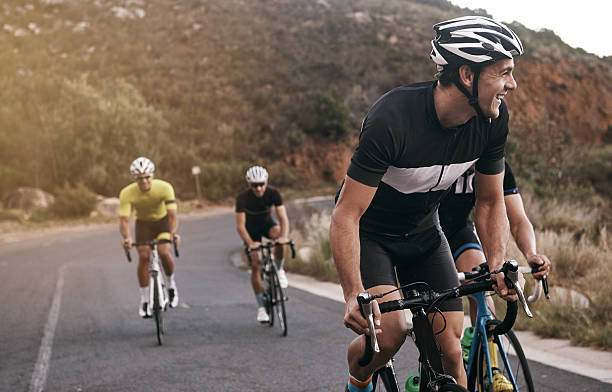

In [6]:
# Gives the user the option to show the name and the content of the chosen image. 
# The required_image index must be between 0 & 3.
#Only 4 images were downloaded as for the purpose of testing this model.
required_image=3
print(f"Image Name: {filenames[required_image].split('/')[-1]}")  # Displaying the image name
image=images[required_image]
image

In [7]:
#Building a function to convert the required image into a tensor and process it for the Llava model
def process_image(image):
    args={"image_aspect_ratio":"pad"}
    image_tensor=process_images(image,image_processor,args)
    return image_tensor.to(model.device,dtype=torch.float16)

In [8]:
#processing the chosen image above using the function developed in the previous step
processed_image=process_image(image)
type(processed_image),processed_image.shape

(torch.Tensor, torch.Size([1, 3, 336, 336]))

In [9]:
#Defining the model that will be used for conversation with the image
CONV_MODE="llava_v0"

In [10]:
#Using the prompt template as per the llava torch documentation
def create_prompt(prompt:str):
    conv=conv_templates[CONV_MODE].copy()
    roles=conv.roles
    prompt=DEFAULT_IMAGE_TOKEN+"\n"+prompt
    conv.append_message(roles[0],prompt)
    conv.append_message(roles[1],None)
    return conv.get_prompt(),conv

In [11]:
#The following is the default system message used by the AI model
prompt,_=create_prompt("Describe the image")
print(prompt)

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.###Human: <image>
Describe the image###Assistant:


In [12]:
#Creating a function to interrogate the images using the model downloaded
def ask_image(image:Image,prompt:str):
    image_tensor=process_image(image)
    prompt,conv=create_prompt(prompt)
    input_ids=(
        tokenizer_image_token(prompt,tokenizer,IMAGE_TOKEN_INDEX,return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )

    stop_str=conv.sep if conv.sep_style!=SeparatorStyle.TWO else conv.sep2
    stopping_criteria= KeywordsStoppingCriteria(keywords=[stop_str],tokenizer=tokenizer,input_ids=input_ids)

    with torch.inference_mode():
        output_ids=model.generate(
            input_ids,
            images=image_tensor,
            do_sample=True,
            temperature=0.01,
            max_new_tokens=512,
            use_cache=True,
            stopping_criteria=[stopping_criteria]
        )
    return tokenizer.decode(
        output_ids[0,input_ids.shape[1]:],skip_special_tokens=True
    ).strip()

In [13]:
%%time
#Using the above parameters for the prompting as well as the processing of the image, tokenizing of the prompt, encoding and decoding within the above function to interrogate the image.
result=ask_image(image,"Describe the image")
print(textwrap.fill(result,width=110))

The image features a group of four men riding bicycles down a road. They are all wearing helmets and appear to
be enjoying their time together. The first man is riding a bicycle on the left side of the road, while the
other three men are riding bicycles in a line on the right side of the road. The group seems to be having a
good time as they ride together, possibly participating in a group ride or a cycling event.
CPU times: user 7.01 s, sys: 673 ms, total: 7.68 s
Wall time: 7.53 s


In [18]:
%%time
#Using the above parameters for the prompting as well as the processing of the image, tokenizing of the prompt, encoding and decoding within the above function to interrogate the image.
result=ask_image(image,"do the cyclists wear helmets?")
print(textwrap.fill(result,width=110))

Yes, the cyclists are wearing helmets for safety while riding their bikes.
CPU times: user 1.86 s, sys: 366 ms, total: 2.23 s
Wall time: 2.11 s


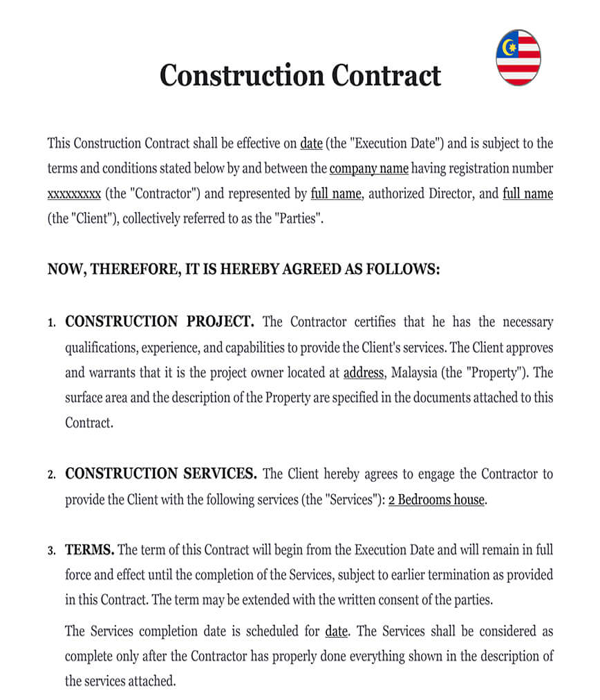

In [22]:
#OCR & Document understanding
image=images[1]
image.resize((600,700))

In [23]:
%%time
#Using the above parameters for the prompting as well as the processing of the image, tokenizing of the prompt, encoding and decoding within the above function to interrogate the image.
result=ask_image(image,"What is the title of the paper?")
print(textwrap.fill(result,width=110))

Construction Contract
CPU times: user 893 ms, sys: 255 ms, total: 1.15 s
Wall time: 1.01 s


In [24]:
%%time
#Using the above parameters for the prompting as well as the processing of the image, tokenizing of the prompt, encoding and decoding within the above function to interrogate the image.
result=ask_image(image,"Summarize the first paragraph.")
print(textwrap.fill(result,width=110))

The first paragraph is a construction contract that outlines the terms and conditions for a project. It
specifies the date of the execution, the parties involved, and the responsibilities of each party. The
contract also includes details about the construction project, such as the scope of work, the payment
schedule, and the completion date.
CPU times: user 4.53 s, sys: 589 ms, total: 5.12 s
Wall time: 5 s
